# Pig Detection CNN Project

This notebook scaffolds the workflow for the HW1 dense pig detection assignment.

## Project Setup

In [13]:
import os
import json
import math
import random
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import itertools
from typing import Dict, List, Tuple

In [14]:
# adjust experiment metadata
EXPERIMENT_NAME = "pig_detection_RelationNet"
OUTPUT_DIR = Path("artifacts") / EXPERIMENT_NAME
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def _prepare_run_directory(base_dir: Path) -> tuple[Path, int]:
    existing = []
    for path in base_dir.iterdir():
        if path.is_dir() and path.name.isdigit():
            try:
                existing.append(int(path.name))
            except ValueError:
                continue
    next_index = max(existing, default=0) + 1
    run_dir = base_dir / f"{next_index}"
    run_dir.mkdir(parents=True, exist_ok=False)
    return run_dir, next_index

RUN_DIR, RUN_ID = _prepare_run_directory(OUTPUT_DIR)

# configure dataset root and annotation paths
DATA_ROOT = Path("../../../taica-cvpdl-2025-hw-1/")
ANNOTATIONS_PATH = DATA_ROOT / "train/gt.txt"
IMAGES_DIR = DATA_ROOT / "train/img"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Logging run {RUN_ID} to {RUN_DIR}")


Using device: cpu
Logging run 2 to artifacts/pig_detection_RelationNet/2


In [15]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# ### TODO ###: choose an appropriate seed value
set_seed(42)


## Data Pipeline

In [16]:
class PigDetectionDataset(Dataset):
    def __init__(self, annotations, images_dir: Path, transforms=None):
        self.annotations = annotations
        self.images_dir = Path(images_dir)
        self.transforms = transforms

    @classmethod
    def from_txt(cls, annotations_path: Path, images_dir: Path, transforms=None):
        annotations_path = Path(annotations_path)
        images_dir = Path(images_dir)
        annotations_by_frame: dict[int, list[list[float]]] = {}

        with open(annotations_path, "r") as fp:
            for line in fp:
                stripped = line.strip()
                if not stripped:
                    continue
                parts = stripped.split(",")
                if len(parts) < 5:
                    continue
                frame_id = int(parts[0])
                bbox = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
                annotations_by_frame.setdefault(frame_id, []).append(bbox)

        records = []
        skipped_frames = []
        for frame_id in sorted(annotations_by_frame.keys()):
            file_name = f"{frame_id:08d}.jpg"
            image_path = images_dir / file_name
            if not image_path.exists():
                skipped_frames.append(file_name)
                continue
            records.append(
                {
                    "image_id": frame_id,
                    "file_name": file_name,
                    "boxes": annotations_by_frame[frame_id],
                    "labels": [1] * len(annotations_by_frame[frame_id]),
                }
            )

        if skipped_frames:
            print(f"Warning: skipped {len(skipped_frames)} annotation entries with missing images.")

        return cls(records, images_dir, transforms)

    def __len__(self) -> int:
        return len(self.annotations)

    def __getitem__(self, idx: int):
        record = self.annotations[idx]
        image_path = self.images_dir / record["file_name"]
        image = Image.open(image_path).convert("RGB")
        image_tensor = torch.as_tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

        boxes = torch.as_tensor(record["boxes"], dtype=torch.float32)
        if boxes.numel() == 0:
            boxes = boxes.view(0, 4)
        labels = torch.as_tensor(record["labels"], dtype=torch.long)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor(record["image_id"], dtype=torch.long),
            "image_size": torch.tensor([image_tensor.shape[1], image_tensor.shape[2]], dtype=torch.int64),
        }

        if self.transforms is not None:
            image_tensor, target = self.transforms(image_tensor, target)
        else:
            target["image_size"] = torch.tensor([image_tensor.shape[1], image_tensor.shape[2]], dtype=torch.int64)

        return image_tensor, target


train_transforms = None
val_transforms = None


In [17]:
def clip_boxes_ltwh_(boxes: torch.Tensor, height: int, width: int) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes
    boxes[:, 0] = boxes[:, 0].clamp_(min=0.0, max=float(width - 1))
    boxes[:, 1] = boxes[:, 1].clamp_(min=0.0, max=float(height - 1))
    boxes[:, 2] = boxes[:, 2].clamp_(min=1.0)
    boxes[:, 3] = boxes[:, 3].clamp_(min=1.0)
    max_width = (width - boxes[:, 0]).clamp(min=1.0)
    max_height = (height - boxes[:, 1]).clamp(min=1.0)
    boxes[:, 2] = torch.minimum(boxes[:, 2], max_width)
    boxes[:, 3] = torch.minimum(boxes[:, 3], max_height)
    return boxes


class ComposeAugmentations:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image: torch.Tensor, target: dict):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip:
    def __init__(self, prob: float = 0.5):
        self.prob = prob

    def __call__(self, image: torch.Tensor, target: dict):
        if torch.rand(1).item() < self.prob:
            image = torch.flip(image, dims=[2])
            width = image.shape[2]
            boxes = target["boxes"]
            if boxes.numel() > 0:
                boxes[:, 0] = width - (boxes[:, 0] + boxes[:, 2])
                clip_boxes_ltwh_(boxes, image.shape[1], width)
                target["boxes"] = boxes
        return image, target


class RandomScaleResize:
    def __init__(self, min_size_choices=(512, 640, 768), max_size: int = 1024):
        self.min_size_choices = min_size_choices
        self.max_size = max_size

    def __call__(self, image: torch.Tensor, target: dict):
        h, w = image.shape[1:]
        short_side = min(h, w)
        choice = float(self.min_size_choices[torch.randint(0, len(self.min_size_choices), (1,)).item()])
        scale = choice / short_side
        new_h = int(round(h * scale))
        new_w = int(round(w * scale))
        if self.max_size is not None:
            max_side = max(new_h, new_w)
            if max_side > self.max_size:
                scale = self.max_size / max_side
                new_h = int(round(new_h * scale))
                new_w = int(round(new_w * scale))

        image = F.interpolate(image.unsqueeze(0), size=(new_h, new_w), mode="bilinear", align_corners=False).squeeze(0)
        boxes = target["boxes"]
        if boxes.numel() > 0:
            scale_w = new_w / w
            scale_h = new_h / h
            boxes[:, 0] *= scale_w
            boxes[:, 2] *= scale_w
            boxes[:, 1] *= scale_h
            boxes[:, 3] *= scale_h
            clip_boxes_ltwh_(boxes, new_h, new_w)
            target["boxes"] = boxes
        target["image_size"] = torch.tensor([new_h, new_w], dtype=torch.int64)
        return image, target


class RandomColorJitter:
    def __init__(self, brightness: float = 0.2, contrast: float = 0.2):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, image: torch.Tensor, target: dict):
        if self.brightness > 0:
            factor = 1.0 + torch.empty(1).uniform_(-self.brightness, self.brightness).item()
            image = image * factor
        if self.contrast > 0:
            mean = image.mean(dim=(1, 2), keepdim=True)
            factor = 1.0 + torch.empty(1).uniform_(-self.contrast, self.contrast).item()
            image = (image - mean) * factor + mean
        image = image.clamp(0.0, 1.0)
        return image, target


class NormalizeImage:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, image: torch.Tensor, target: dict):
        image = (image - self.mean.to(image.device)) / self.std.to(image.device)
        return image, target


class PadToStride:
    def __init__(self, stride: int = 32, value: float = 0.0):
        self.stride = stride
        self.value = value

    def __call__(self, image: torch.Tensor, target: dict):
        h, w = image.shape[1:]
        pad_h = (self.stride - h % self.stride) % self.stride
        pad_w = (self.stride - w % self.stride) % self.stride
        if pad_h > 0 or pad_w > 0:
            image = F.pad(image, (0, pad_w, 0, pad_h), value=self.value)
        target["image_size"] = torch.tensor([image.shape[1], image.shape[2]], dtype=torch.int64)
        return image, target


def build_augmentation_pipeline(train: bool = True):
    if train:
        return ComposeAugmentations(
            [
                RandomScaleResize(),
                RandomHorizontalFlip(0.5),
                RandomColorJitter(0.2, 0.2),
                NormalizeImage(),
                PadToStride(stride=32),
            ]
        )
    return ComposeAugmentations(
        [
            RandomScaleResize(min_size_choices=(640,), max_size=1024),
            NormalizeImage(),
            PadToStride(stride=32),
        ]
    )


train_transforms = build_augmentation_pipeline(train=True)
val_transforms = build_augmentation_pipeline(train=False)


In [18]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [img if torch.is_tensor(img) else torch.as_tensor(img, dtype=torch.float32) for img in images]
    return list(images), list(targets)


def create_dataloaders(
    batch_size: int = 4,
    num_workers: int = 0,
    val_ratio: float = 0.2,
    seed: int = 42,
):
    """Create train/validation dataloaders with a deterministic split."""
    base_dataset = PigDetectionDataset.from_txt(
        ANNOTATIONS_PATH,
        IMAGES_DIR,
        transforms=None,
    )

    num_samples = len(base_dataset)
    if num_samples == 0:
        raise ValueError("Dataset is empty; check annotation and image paths.")

    indices = list(range(num_samples))
    random.Random(seed).shuffle(indices)

    val_size = max(1, int(num_samples * val_ratio))
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    train_annotations = [base_dataset.annotations[i] for i in train_indices]
    val_annotations = [base_dataset.annotations[i] for i in val_indices]

    train_dataset = PigDetectionDataset(
        train_annotations,
        IMAGES_DIR,
        transforms=train_transforms,
    )
    val_dataset = PigDetectionDataset(
        val_annotations,
        IMAGES_DIR,
        transforms=val_transforms,
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    return train_loader, val_loader


train_loader, val_loader = create_dataloaders(batch_size=4, num_workers=0, val_ratio=0.2, seed=42)


## Model Definition

In [19]:

# Model definition using a DDOD-style architecture trained from scratch

def boxes_ltwh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]
    return torch.stack((x1, y1, x2, y2), dim=-1)


def boxes_xyxy_to_ltwh(boxes: torch.Tensor) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    width = boxes[:, 2] - boxes[:, 0]
    height = boxes[:, 3] - boxes[:, 1]
    return torch.stack((boxes[:, 0], boxes[:, 1], width, height), dim=-1)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class SimpleResNetBackbone(nn.Module):
    """A lightweight ResNet-style backbone trained from scratch."""

    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_stage(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_stage(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_stage(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_stage(256, 512, blocks=2, stride=2)
        self._initialize_weights()

    def _make_stage(self, in_channels: int, out_channels: int, blocks: int, stride: int) -> nn.Sequential:
        layers = [BasicBlock(in_channels, out_channels, stride=stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        x = self.stem(x)
        x = self.maxpool(x)
        c2 = self.layer1(x)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        return [c3, c4, c5]


class FeaturePyramid(nn.Module):
    def __init__(self, in_channels_list=(128, 256, 512), out_channels: int = 256):
        super().__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])
        self.output_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])
        self.p6 = nn.Conv2d(in_channels_list[-1], out_channels, kernel_size=3, stride=2, padding=1)
        self.p7 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, features: List[torch.Tensor]) -> List[torch.Tensor]:
        c3, c4, c5 = features
        latents = []
        prev = None
        for feat, lat_conv in zip([c3, c4, c5], self.lateral_convs):
            latents.append(lat_conv(feat))
        p5 = self.output_convs[2](latents[2])
        p4 = self.output_convs[1](latents[1] + F.interpolate(p5, size=latents[1].shape[-2:], mode="nearest"))
        p3 = self.output_convs[0](latents[0] + F.interpolate(p4, size=latents[0].shape[-2:], mode="nearest"))
        p6 = self.p6(features[-1])
        p7 = self.p7(F.relu(p6))
        return [p3, p4, p5, p6, p7]


def conv3x3(cin, cout, stride=1, dilation=1, gn_groups=32):
    return nn.Sequential(
        nn.Conv2d(cin, cout, 3, stride=stride, padding=dilation, dilation=dilation, bias=False),
        nn.GroupNorm(gn_groups, cout),
        nn.ReLU(inplace=True),
    )


class Scale(nn.Module):
    def __init__(self, init_value=1.0):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(float(init_value)))

    def forward(self, x):
        return x * self.scale


def init_cls_logits_bias(module: nn.Conv2d, prior_prob: float = 0.01):
    bias_value = -math.log((1 - prior_prob) / prior_prob)
    nn.init.constant_(module.bias, bias_value)


class TaskTower(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_convs: int, dilation: int = 1):
        super().__init__()
        blocks = []
        c = in_channels
        for _ in range(num_convs):
            blocks.append(conv3x3(c, out_channels, dilation=dilation))
            c = out_channels
        self.net = nn.Sequential(*blocks)

    def forward(self, x):
        return self.net(x)


class DDODHead(nn.Module):
    def __init__(
        self,
        num_classes: int,
        in_channels: int = 256,
        feat_channels: int = 256,
        cls_num_convs: int = 4,
        reg_num_convs: int = 4,
        cls_dilation: int = 1,
        reg_dilation: int = 1,
        fpn_strides: Tuple[int, ...] = (8, 16, 32, 64, 128),
        use_centerness: bool = True,
        prior_prob: float = 0.01,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.fpn_strides = fpn_strides
        self.use_centerness = use_centerness

        self.cls_tower = TaskTower(in_channels, feat_channels, cls_num_convs, dilation=cls_dilation)
        self.reg_tower = TaskTower(in_channels, feat_channels, reg_num_convs, dilation=reg_dilation)

        self.cls_logits = nn.Conv2d(feat_channels, num_classes, kernel_size=3, padding=1)
        self.bbox_pred = nn.Conv2d(feat_channels, 4, kernel_size=3, padding=1)
        self.centerness = nn.Conv2d(feat_channels, 1, kernel_size=3, padding=1) if use_centerness else None

        self.scales = nn.ModuleList([Scale(1.0) for _ in fpn_strides])

        modules = [self.cls_tower, self.reg_tower, self.cls_logits, self.bbox_pred]
        if self.centerness is not None:
            modules.append(self.centerness)
        for module in modules:
            for m in module.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.normal_(m.weight, std=0.01)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0.0)
        init_cls_logits_bias(self.cls_logits, prior_prob)

    @torch.no_grad()
    def _compute_locations(self, feat: torch.Tensor, stride: int) -> torch.Tensor:
        h, w = feat.shape[-2:]
        device = feat.device
        shifts_x = torch.arange(0, w * stride, step=stride, device=device) + stride // 2
        shifts_y = torch.arange(0, h * stride, step=stride, device=device) + stride // 2
        yy, xx = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
        return torch.stack((xx, yy), dim=-1).reshape(-1, 2)

    def forward(self, feats: List[torch.Tensor]) -> Dict[str, List[torch.Tensor]]:
        cls_outs, reg_outs, ctr_outs, pts_outs = [], [], [], []
        for level, (x, stride) in enumerate(zip(feats, self.fpn_strides)):
            cls_feat = self.cls_tower(x)
            reg_feat = self.reg_tower(x)

            cls_logits = self.cls_logits(cls_feat)
            bbox_deltas = self.scales[level](self.bbox_pred(reg_feat))
            bbox_deltas = F.relu(bbox_deltas)

            cls_outs.append(cls_logits)
            reg_outs.append(bbox_deltas)
            if self.centerness is not None:
                ctr_outs.append(self.centerness(reg_feat))

            pts_outs.append(self._compute_locations(x, stride))

        outputs = {
            "cls_logits": cls_outs,
            "bbox_deltas": reg_outs,
            "points": pts_outs,
        }
        if self.centerness is not None:
            outputs["centerness"] = ctr_outs
        return outputs


class DDODDetector(nn.Module):
    def __init__(self, num_classes: int = 1):
        super().__init__()
        self.backbone = SimpleResNetBackbone()
        self.fpn = FeaturePyramid()
        self.head = DDODHead(num_classes=num_classes)

    def forward(self, images: torch.Tensor) -> Dict[str, List[torch.Tensor]]:
        features = self.backbone(images)
        pyramid = self.fpn(features)
        outputs = self.head(pyramid)
        return outputs


def build_model(num_classes: int = 1) -> DDODDetector:
    model = DDODDetector(num_classes=num_classes)
    return model.to(DEVICE)


model = build_model(num_classes=1)
print(model)


DDODDetector(
  (backbone): SimpleResNetBackbone(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, 

In [20]:

FPN_STRIDES = (8, 16, 32, 64, 128)
SIZES_OF_INTEREST = (
    (0, 64),
    (64, 128),
    (128, 256),
    (256, 512),
    (512, 1e8),
)
EPS = 1e-8


def distances_to_boxes(points: torch.Tensor, deltas: torch.Tensor) -> torch.Tensor:
    x = points[:, 0]
    y = points[:, 1]
    l = deltas[:, 0]
    t = deltas[:, 1]
    r = deltas[:, 2]
    b = deltas[:, 3]
    x1 = x - l
    y1 = y - t
    x2 = x + r
    y2 = y + b
    return torch.stack((x1, y1, x2, y2), dim=-1)


def box_area(boxes: torch.Tensor) -> torch.Tensor:
    return (boxes[:, 2] - boxes[:, 0]).clamp(min=0) * (boxes[:, 3] - boxes[:, 1]).clamp(min=0)


def box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return boxes1.new_zeros((boxes1.size(0), boxes2.size(0)))
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]
    union = area1[:, None] + area2 - inter + EPS
    return inter / union


def generalized_box_iou(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    inter_x1 = torch.max(pred[:, 0], target[:, 0])
    inter_y1 = torch.max(pred[:, 1], target[:, 1])
    inter_x2 = torch.min(pred[:, 2], target[:, 2])
    inter_y2 = torch.min(pred[:, 3], target[:, 3])

    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter = inter_w * inter_h

    area_pred = box_area(pred)
    area_target = box_area(target)
    union = area_pred + area_target - inter + EPS

    iou = inter / union

    enclose_x1 = torch.min(pred[:, 0], target[:, 0])
    enclose_y1 = torch.min(pred[:, 1], target[:, 1])
    enclose_x2 = torch.max(pred[:, 2], target[:, 2])
    enclose_y2 = torch.max(pred[:, 3], target[:, 3])

    enclose_w = (enclose_x2 - enclose_x1).clamp(min=0)
    enclose_h = (enclose_y2 - enclose_y1).clamp(min=0)
    enclose_area = enclose_w * enclose_h + EPS

    giou = iou - (enclose_area - union) / enclose_area
    return giou


def focal_loss(logits: torch.Tensor, labels: torch.Tensor, num_classes: int, alpha: float = 0.25, gamma: float = 2.0, normalizer: torch.Tensor | float = 1.0) -> torch.Tensor:
    target = torch.zeros_like(logits)
    positive = labels > 0
    if positive.any():
        class_indices = labels[positive] - 1
        target[positive, class_indices] = 1.0

    prob = torch.sigmoid(logits)
    ce_loss = F.binary_cross_entropy_with_logits(logits, target, reduction="none")

    p_t = prob * target + (1 - prob) * (1 - target)
    alpha_factor = target * alpha + (1 - target) * (1 - alpha)
    modulating = torch.pow((1 - p_t).clamp(min=0.0, max=1.0), gamma)
    loss = (alpha_factor * modulating * ce_loss).sum()

    if isinstance(normalizer, torch.Tensor):
        normalizer = normalizer.clamp(min=1.0).item()
    else:
        normalizer = max(normalizer, 1.0)
    return loss / normalizer


def compute_centerness_targets(bbox_targets: torch.Tensor) -> torch.Tensor:
    left_right = bbox_targets[:, [0, 2]]
    top_bottom = bbox_targets[:, [1, 3]]
    centerness = torch.sqrt(
        (left_right.min(dim=1).values / left_right.max(dim=1).values.clamp(min=EPS)) *
        (top_bottom.min(dim=1).values / top_bottom.max(dim=1).values.clamp(min=EPS))
    )
    return centerness


def generate_targets_per_image(
    points: torch.Tensor,
    sizes_of_interest: torch.Tensor,
    gt_boxes_ltwh: torch.Tensor,
    gt_labels: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    num_points = points.size(0)
    device = points.device
    labels = torch.zeros(num_points, dtype=torch.long, device=device)
    bbox_targets = torch.zeros(num_points, 4, dtype=torch.float32, device=device)
    centerness = torch.zeros(num_points, dtype=torch.float32, device=device)

    if gt_boxes_ltwh.numel() == 0:
        return labels, bbox_targets, centerness

    gt_boxes = boxes_ltwh_to_xyxy(gt_boxes_ltwh.to(device))
    gt_labels = gt_labels.to(device)
    areas = box_area(gt_boxes)

    xs = points[:, 0][:, None]
    ys = points[:, 1][:, None]

    l = xs - gt_boxes[:, 0]
    t = ys - gt_boxes[:, 1]
    r = gt_boxes[:, 2] - xs
    b = gt_boxes[:, 3] - ys
    reg_targets = torch.stack([l, t, r, b], dim=2)

    is_inside_box = reg_targets.min(dim=2).values > 0
    max_reg_targets = reg_targets.max(dim=2).values

    min_size, max_size = sizes_of_interest[:, 0][:, None], sizes_of_interest[:, 1][:, None]
    is_cared_in_level = (max_reg_targets >= min_size) & (max_reg_targets <= max_size)

    areas = areas[None, :].repeat(num_points, 1)
    areas[~(is_inside_box & is_cared_in_level)] = float("inf")

    min_areas, min_inds = areas.min(dim=1)
    labels = torch.where(min_areas < float("inf"), gt_labels[min_inds], torch.zeros_like(min_inds))

    pos_inds = torch.where(labels > 0)[0]
    if pos_inds.numel() > 0:
        best_regs = reg_targets[pos_inds, min_inds[pos_inds]]
        bbox_targets[pos_inds] = best_regs
        centerness[pos_inds] = compute_centerness_targets(best_regs)
    return labels, bbox_targets, centerness


def generate_targets(points_per_level: List[torch.Tensor], targets: List[dict]):
    device = points_per_level[0].device
    num_points_per_level = [len(p) for p in points_per_level]
    points = torch.cat(points_per_level, dim=0).to(device)

    sizes = []
    for (min_size, max_size), num_points in zip(SIZES_OF_INTEREST, num_points_per_level):
        sizes.append(points.new_tensor([min_size, max_size]).unsqueeze(0).repeat(num_points, 1))
    sizes_of_interest = torch.cat(sizes, dim=0)

    labels_list = []
    bbox_targets_list = []
    centerness_list = []
    for target in targets:
        labels, bbox_targets, centerness = generate_targets_per_image(
            points,
            sizes_of_interest,
            target["boxes"],
            target["labels"],
        )
        labels_list.append(labels)
        bbox_targets_list.append(bbox_targets)
        centerness_list.append(centerness)

    labels = torch.stack(labels_list)  # [B, P]
    bbox_targets = torch.stack(bbox_targets_list)
    centerness = torch.stack(centerness_list)
    return labels, bbox_targets, centerness, points, torch.tensor(num_points_per_level, device=device)


def flatten_outputs(outputs: Dict[str, List[torch.Tensor]]):
    cls_logits, bbox_deltas = outputs["cls_logits"], outputs["bbox_deltas"]
    centerness = outputs.get("centerness")
    batch_size = cls_logits[0].shape[0]
    num_classes = cls_logits[0].shape[1]

    cls_flattened = []
    bbox_flattened = []
    centerness_flattened = []
    for level in range(len(cls_logits)):
        cls = cls_logits[level].permute(0, 2, 3, 1).reshape(batch_size, -1, num_classes)
        reg = bbox_deltas[level].permute(0, 2, 3, 1).reshape(batch_size, -1, 4)
        cls_flattened.append(cls)
        bbox_flattened.append(reg)
        if centerness is not None:
            ctr = centerness[level].permute(0, 2, 3, 1).reshape(batch_size, -1, 1)
            centerness_flattened.append(ctr)

    cls_flattened = torch.cat(cls_flattened, dim=1)
    bbox_flattened = torch.cat(bbox_flattened, dim=1)
    if centerness is not None:
        centerness_flattened = torch.cat(centerness_flattened, dim=1)
    else:
        centerness_flattened = None

    return cls_flattened, bbox_flattened, centerness_flattened


def compute_loss(outputs, targets):
    cls_preds, bbox_preds, centerness_preds = flatten_outputs(outputs)
    batch_size, num_points, num_classes = cls_preds.shape
    device = cls_preds.device

    points_per_level = [p.to(device) for p in outputs["points"]]
    labels, bbox_targets, centerness_targets, points, num_points_per_level = generate_targets(points_per_level, targets)
    labels = labels.to(device)
    bbox_targets = bbox_targets.to(device)
    centerness_targets = centerness_targets.to(device)

    cls_preds_flat = cls_preds.reshape(-1, num_classes)
    bbox_preds_flat = bbox_preds.reshape(-1, 4)
    labels_flat = labels.reshape(-1)
    bbox_targets_flat = bbox_targets.reshape(-1, 4)
    centerness_targets_flat = centerness_targets.reshape(-1)

    cls_loss = focal_loss(cls_preds_flat, labels_flat, num_classes=num_classes, normalizer=(labels_flat > 0).sum())

    loss_bbox = torch.tensor(0.0, device=device)
    loss_centerness = torch.tensor(0.0, device=device)

    positive_mask = labels_flat > 0
    num_positive = positive_mask.sum()
    if num_positive > 0:
        points_all = torch.cat([p.to(device) for p in outputs["points"]], dim=0)
        points_all = points_all.unsqueeze(0).repeat(batch_size, 1, 1).reshape(-1, 2)

        bbox_preds_pos = bbox_preds_flat[positive_mask]
        bbox_targets_pos = bbox_targets_flat[positive_mask]
        centerness_targets_pos = centerness_targets_flat[positive_mask]
        points_pos = points_all[positive_mask]

        pred_boxes = distances_to_boxes(points_pos, bbox_preds_pos)
        target_boxes = distances_to_boxes(points_pos, bbox_targets_pos)

        giou = generalized_box_iou(pred_boxes, target_boxes)
        giou_loss = (1.0 - giou) * centerness_targets_pos
        normalization = centerness_targets_pos.sum().clamp(min=1.0)
        loss_bbox = giou_loss.sum() / normalization

        if centerness_preds is not None:
            centerness_preds_flat = centerness_preds.reshape(-1)
            centerness_preds_pos = centerness_preds_flat[positive_mask]
            loss_centerness = F.binary_cross_entropy_with_logits(
                centerness_preds_pos,
                centerness_targets_pos,
                reduction="sum",
            ) / normalization

    total_loss = cls_loss + loss_bbox + loss_centerness
    return total_loss


def decode_detections(
    outputs: Dict[str, List[torch.Tensor]],
    score_threshold: float = 0.05,
    topk: int = 300,
) -> List[Dict[str, torch.Tensor]]:
    cls_preds, bbox_preds, centerness_preds = flatten_outputs(outputs)
    batch_size, num_points, num_classes = cls_preds.shape
    device = cls_preds.device

    points = torch.cat([p.to(device) for p in outputs["points"]], dim=0)
    points = points.unsqueeze(0).repeat(batch_size, 1, 1)

    scores = torch.sigmoid(cls_preds)
    if centerness_preds is not None:
        scores = scores * torch.sigmoid(centerness_preds)

    results = []
    for i in range(batch_size):
        score_per_image = scores[i]
        bbox_per_image = bbox_preds[i]
        points_per_image = points[i]

        score_per_image, labels = score_per_image.max(dim=1)
        keep = score_per_image >= score_threshold

        score_per_image = score_per_image[keep]
        labels = labels[keep]
        bbox_per_image = bbox_per_image[keep]
        points_kept = points_per_image[keep]

        if score_per_image.numel() == 0:
            results.append({"boxes": torch.zeros((0, 4), device=device), "scores": torch.zeros((0,), device=device), "labels": torch.zeros((0,), dtype=torch.long, device=device)})
            continue

        if topk is not None and score_per_image.numel() > topk:
            scores_topk, idx = torch.topk(score_per_image, topk)
            score_per_image = scores_topk
            labels = labels[idx]
            bbox_per_image = bbox_per_image[idx]
            points_kept = points_kept[idx]

        boxes = distances_to_boxes(points_kept, bbox_per_image)
        labels = labels + 1  # shift to match dataset label convention
        results.append({"boxes": boxes, "scores": score_per_image, "labels": labels})
    return results


def compute_metrics(outputs, targets, iou_thresholds=torch.arange(0.5, 1.0, 0.05)):
    detections = decode_detections(outputs, score_threshold=0.05, topk=300)
    metrics = {"mAP@0.5:0.95": 0.0}
    num_images = len(targets)
    ap_sums = torch.zeros(len(iou_thresholds))

    for det, tgt in zip(detections, targets):
        gt_boxes = tgt["boxes"].to(det["boxes"].device)
        gt_labels = tgt["labels"].to(det["boxes"].device)
        if gt_boxes.numel() > 0:
            gt_boxes = boxes_ltwh_to_xyxy(gt_boxes)
        else:
            gt_boxes = gt_boxes.new_zeros((0, 4))

        pred_boxes = det["boxes"]
        pred_scores = det["scores"]

        if gt_boxes.numel() == 0 or pred_boxes.numel() == 0:
            continue

        order = torch.argsort(pred_scores, descending=True)
        pred_boxes = pred_boxes[order]
        pred_scores = pred_scores[order]

        iou_mat = box_iou(pred_boxes, gt_boxes)
        for idx, thr in enumerate(iou_thresholds):
            matched = torch.zeros(gt_boxes.size(0), dtype=torch.bool, device=gt_boxes.device)
            matched_ious = []
            for pred_idx in range(pred_boxes.size(0)):
                ious = iou_mat[pred_idx]
                max_iou, max_idx = ious.max(dim=0)
                if max_iou >= thr and not matched[max_idx]:
                    matched[max_idx] = True
                    matched_ious.append(max_iou.item())
            tp = float(len(matched_ious))
            fp = float(pred_boxes.size(0) - tp)
            precision = tp / (tp + fp + EPS) if (tp + fp) > 0 else 0.0
            ap_sums[idx] += precision
            if abs(float(thr) - 0.5) < 1e-6 and matched_ious:
                iou_accumulator.extend(matched_ious)

    if num_images > 0:
        mean_ap = (ap_sums / max(num_images, 1)).mean().item()
    else:
        mean_ap = 0.0
    metrics["mAP@0.5:0.95"] = mean_ap
    for thr, ap in zip(iou_thresholds.tolist(), ap_sums.tolist()):
        metrics[f"AP@{thr:.2f}"] = ap / max(num_images, 1)
    if iou_accumulator:
        metrics["IoU_mean"] = sum(iou_accumulator) / len(iou_accumulator)
    else:
        metrics["IoU_mean"] = 0.0
    return metrics


## Optimization

In [21]:
# ### TODO ###: configure optimizer, LR scheduler, and training hyperparameters
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = None  # ### TODO ###: optionally add LR scheduler


## Training Loop

In [22]:

def _prepare_batch(images, targets):
    processed_images = []
    processed_targets = []
    heights = []
    widths = []

    for img, tgt in zip(images, targets):
        if not torch.is_tensor(img):
            img = torch.as_tensor(img, dtype=torch.float32)
        img = img.float()
        if img.dim() == 3 and img.max() > 1.0:
            img = img / 255.0
        processed_images.append(img)
        heights.append(img.shape[1])
        widths.append(img.shape[2])

        processed_target = {}
        if isinstance(tgt, dict):
            for key, value in tgt.items():
                if torch.is_tensor(value):
                    processed_target[key] = value.clone()
                else:
                    processed_target[key] = value
            if "image_size" not in processed_target:
                processed_target["image_size"] = torch.tensor([img.shape[1], img.shape[2]], dtype=torch.int64)
            else:
                processed_target["image_size"] = processed_target["image_size"].clone()
        processed_targets.append(processed_target)

    max_h = max(heights)
    max_w = max(widths)

    padded_images = []
    for img, tgt in zip(processed_images, processed_targets):
        pad_h = max_h - img.shape[1]
        pad_w = max_w - img.shape[2]
        if pad_h > 0 or pad_w > 0:
            img = F.pad(img, (0, pad_w, 0, pad_h), value=0.0)
        padded_images.append(img.to(DEVICE))

        tgt["padded_image_size"] = torch.tensor([max_h, max_w], dtype=torch.int64, device=DEVICE)
        if isinstance(tgt.get("image_size"), torch.Tensor):
            tgt["image_size"] = tgt["image_size"].to(DEVICE)

        for key, value in list(tgt.items()):
            if isinstance(value, torch.Tensor) and key not in {"padded_image_size", "image_size"}:
                tgt[key] = value.to(DEVICE)

    batch_images = torch.stack(padded_images)
    return batch_images, processed_targets


def train_one_epoch(model, dataloader, optimizer, log_interval: int = 10):
    model.train()
    running_loss = 0.0

    for step, (images, targets) in enumerate(dataloader):
        images, targets = _prepare_batch(images, targets)

        outputs = model(images)
        loss = compute_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step + 1) % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            print(f"step {step + 1}: loss={avg_loss:.4f}")
    return running_loss / max(1, len(dataloader))


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    eval_loss = 0.0
    metric_totals = {}
    batches = 0

    for images, targets in dataloader:
        images, targets = _prepare_batch(images, targets)

        outputs = model(images)
        loss = compute_loss(outputs, targets)
        eval_loss += loss.item()

        metrics = compute_metrics(outputs, targets)
        for key, value in metrics.items():
            metric_totals[key] = metric_totals.get(key, 0.0) + float(value)
        batches += 1

    eval_loss /= max(1, batches)
    aggregated_metrics = {k: v / max(1, batches) for k, v in metric_totals.items()}
    return eval_loss, aggregated_metrics


In [23]:
def save_checkpoint(model, optimizer, epoch, best_metric=None):
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "best_metric": best_metric,
    }
    RUN_DIR.mkdir(parents=True, exist_ok=True)
    ckpt_path = RUN_DIR / f"checkpoint_epoch_{epoch:03d}.pth"
    torch.save(checkpoint, ckpt_path)
    return ckpt_path

def load_checkpoint(model, optimizer, checkpoint_path: Path):
    state = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(state["model_state"])
    optimizer.load_state_dict(state["optimizer_state"])
    return state


In [ ]:
best_val_metric = None
no_improve_epochs = 0
patience = 5  # stop if no improvement for this many epochs
history = {"train_loss": [], "val_loss": [], "val_metrics": []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_metrics = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_metrics"].append(val_metrics)

    metric_str = ", ".join(f"{k}={v:.4f}" for k, v in val_metrics.items())
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, {metric_str}")

    if scheduler is not None:
        scheduler.step()

    current_metric = val_metrics.get("mAP@0.5:0.95", None)
    if current_metric is not None:
        if best_val_metric is None or current_metric > best_val_metric:
            best_val_metric = current_metric
            no_improve_epochs = 0
            best_path = OUTPUT_DIR / "best.pth"
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch,
                "best_metric": best_val_metric,
            }, best_path)
            print(f"Saved new best checkpoint to {best_path} (mAP@0.5:0.95={best_val_metric:.4f})")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping: no improvement in validation metric.")
                break
    save_checkpoint(model, optimizer, epoch, best_metric=best_val_metric)

history_entry = {
    "run_id": RUN_ID,
    "run_dir": str(RUN_DIR),
    "history": history,
    "best_metric": best_val_metric,
    "epochs": len(history["train_loss"]),
    "timestamp": datetime.now().isoformat(),
}

history_path = OUTPUT_DIR / "history.json"
if history_path.exists():
    try:
        with open(history_path, "r") as fp:
            history_log = json.load(fp)
    except json.JSONDecodeError:
        history_log = []
else:
    history_log = []

if isinstance(history_log, dict):
    history_log = [history_log]

history_log.append(history_entry)

with open(history_path, "w") as fp:
    json.dump(history_log, fp, indent=2)
print(f"Training history appended to {history_path}")


step 10: loss=3.6821
step 20: loss=3.3572
step 30: loss=3.2302


## Evaluation & Visualization

Loaded checkpoint from artifacts/pig_detection_baseline/best.pth (epoch=1, best_metric=0.0)
Validation loss: 0.0000
  mAP@0.5:0.95: 0.0000
  AP@0.50: 0.0000
  AP@0.55: 0.0000
  AP@0.60: 0.0000
  AP@0.65: 0.0000
  AP@0.70: 0.0000
  AP@0.75: 0.0000
  AP@0.80: 0.0000
  AP@0.85: 0.0000
  AP@0.90: 0.0000
  AP@0.95: 0.0000
  IoU_mean: 0.0000


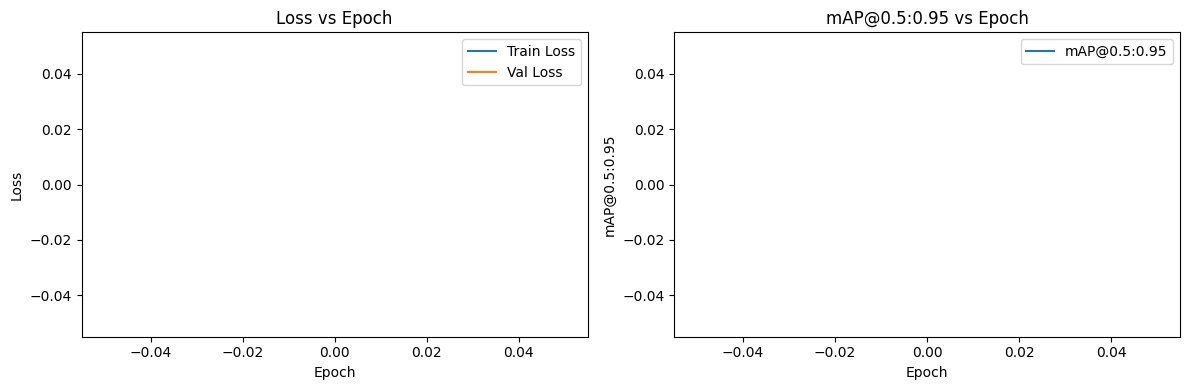

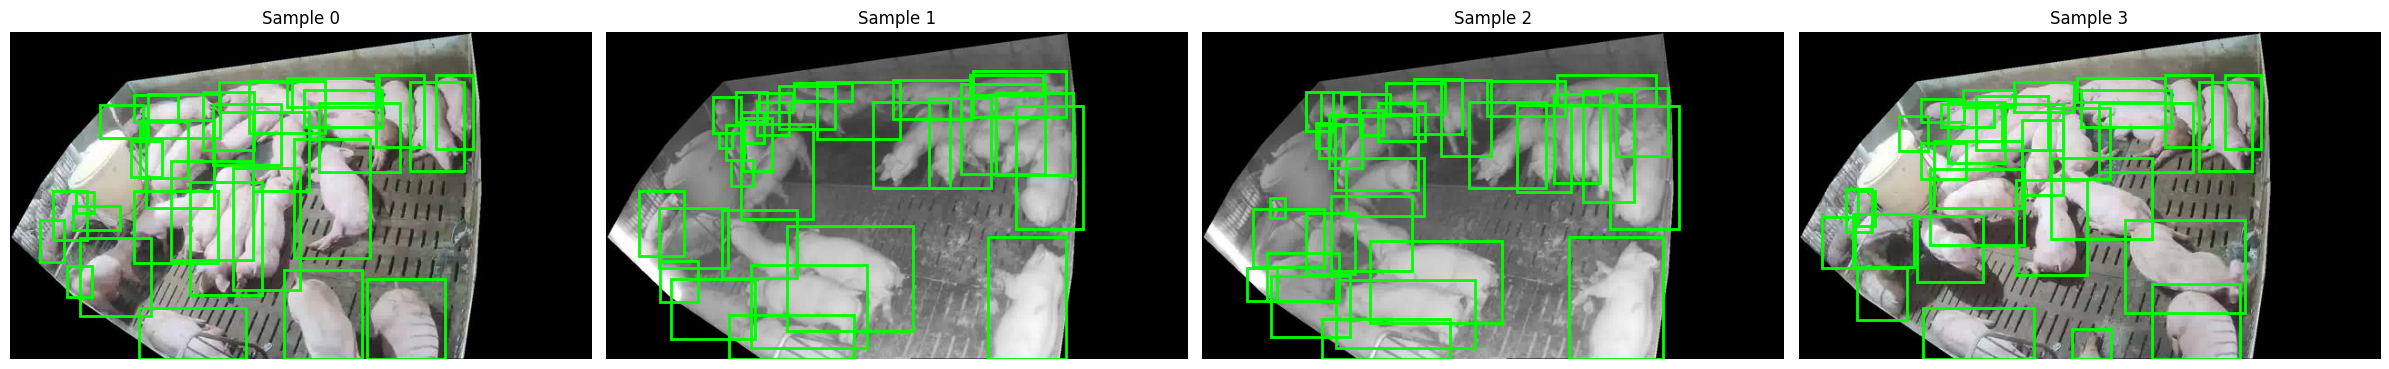

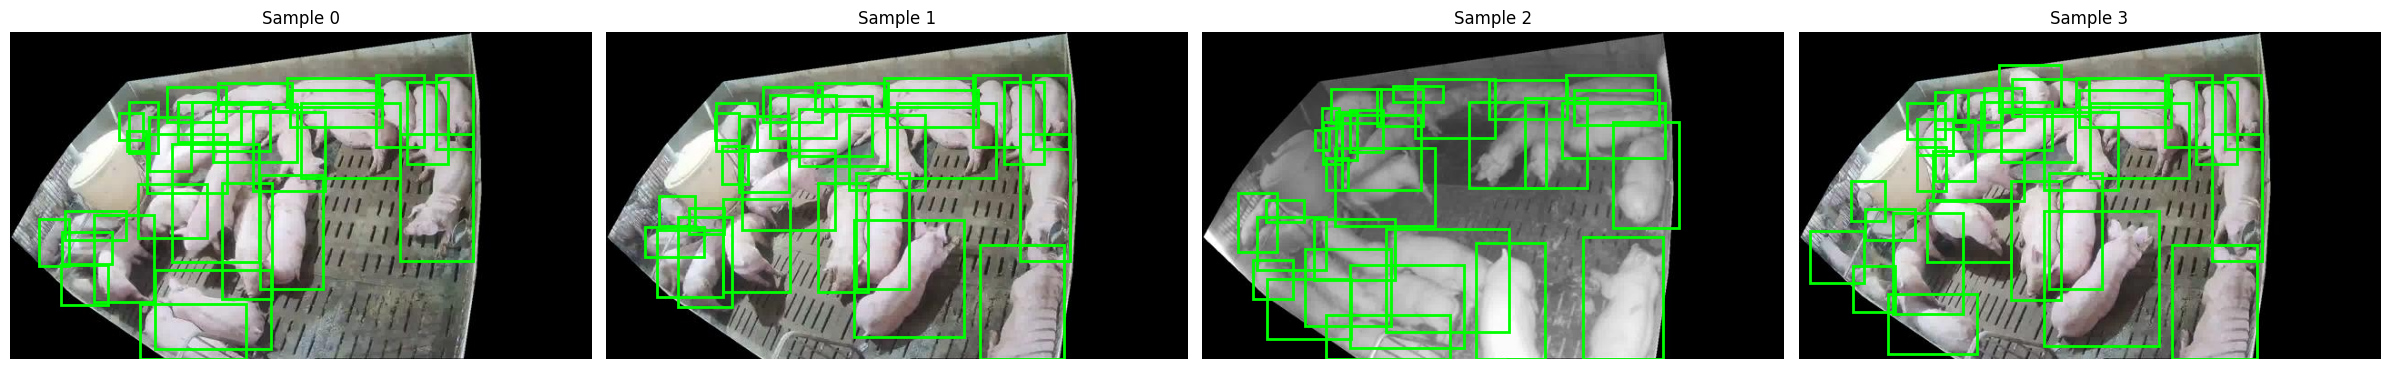

In [ ]:

def plot_training_history(history_dict, metric_key: str = "mAP@0.5:0.95"):
    epochs = range(1, len(history_dict.get("train_loss", [])) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, history_dict.get("train_loss", []), label="Train Loss")
    axes[0].plot(epochs, history_dict.get("val_loss", []), label="Val Loss")
    axes[0].set_title("Loss vs Epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    metric_values = [metrics.get(metric_key, 0.0) for metrics in history_dict.get("val_metrics", [])]
    axes[1].plot(epochs, metric_values, label=metric_key)
    axes[1].set_title(f"{metric_key} vs Epoch")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel(metric_key)
    axes[1].legend()

    plt.tight_layout()
    return fig


def _to_numpy_image(image_tensor: torch.Tensor) -> np.ndarray:
    img = image_tensor.detach().cpu().float()
    if img.ndim == 2:
        img = img.unsqueeze(0)
    if img.ndim == 3:
        img = img.permute(1, 2, 0)
    img = img.clamp(0.0, 1.0).numpy()
    return img


def visualize_predictions(images, targets, outputs, score_threshold: float = 0.3, max_images: int = 4):
    detections = decode_detections(outputs, score_threshold=score_threshold, topk=200)
    batch_size = min(len(images), max_images)
    fig, axes = plt.subplots(1, batch_size, figsize=(6 * batch_size, 6))
    if batch_size == 1:
        axes = [axes]

    for idx in range(batch_size):
        ax = axes[idx]
        img = _to_numpy_image(images[idx])
        ax.imshow(img)
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

        target = targets[idx]
        gt_boxes = target.get("boxes") if isinstance(target, dict) else None
        if gt_boxes is not None and gt_boxes.numel() > 0:
            gt_boxes_xyxy = boxes_ltwh_to_xyxy(gt_boxes.detach().cpu())
            for box in gt_boxes_xyxy:
                x1, y1, x2, y2 = box.tolist()
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="lime", facecolor="none")
                ax.add_patch(rect)

        preds = detections[idx]
        pred_boxes = preds["boxes"].detach().cpu()
        pred_scores = preds["scores"].detach().cpu()
        for box, score in zip(pred_boxes, pred_scores):
            x1, y1, x2, y2 = box.tolist()
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none", linestyle="--")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=9, backgroundcolor="white")

    plt.tight_layout()
    return fig


def run_validation_and_visualization(
    model,
    dataloader,
    checkpoint_path: Path | None = None,
    visualize_batches: int = 1,
    score_threshold: float = 0.3,
):
    if checkpoint_path is not None and checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint from {checkpoint_path} (epoch={state.get('epoch')}, best_metric={state.get('best_metric')})")
    else:
        print("Using current model weights for evaluation.")

    val_loss, val_metrics = evaluate(model, dataloader)
    print(f"Validation loss: {val_loss:.4f}")
    for key, value in val_metrics.items():
        print(f"  {key}: {value:.4f}")

    if visualize_batches <= 0:
        return

    model.eval()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            prepared_images, prepared_targets = _prepare_batch(images, targets)
            outputs = model(prepared_images)
            detections = decode_detections(outputs, score_threshold=score_threshold, topk=200)
            fig = visualize_predictions(prepared_images.detach().cpu(), prepared_targets, outputs, score_threshold=score_threshold)
            plt.show()
            if batch_idx + 1 >= visualize_batches:
                break


## Inference

In [ ]:
def _load_image_as_tensor(image):
    if isinstance(image, (str, Path)):
        image = Image.open(image).convert("RGB")
    if isinstance(image, Image.Image):
        image = np.array(image)
    if torch.is_tensor(image):
        img_tensor = image.clone().detach().float()
        if img_tensor.ndim == 3 and img_tensor.size(0) in (1, 3):
            if img_tensor.max() > 1.0:
                img_tensor = img_tensor / 255.0
        elif img_tensor.ndim == 3:
            img_tensor = img_tensor.permute(2, 0, 1).float() / 255.0
    else:
        img_tensor = torch.as_tensor(image).float()
        if img_tensor.ndim == 3:
            img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = img_tensor / 255.0
    if img_tensor.ndim == 2:
        img_tensor = img_tensor.unsqueeze(0)
    if img_tensor.ndim != 3:
        raise ValueError("Image must be convertible to a CxHxW tensor.")
    if img_tensor.size(0) == 1:
        img_tensor = img_tensor.expand(3, -1, -1)
    return img_tensor.clamp(0.0, 1.0)


@torch.no_grad()
def run_inference(model, image, score_threshold: float = 0.5, max_detections: int | None = None):
    model.eval()
    image_tensor = _load_image_as_tensor(image)
    image_batch = image_tensor.unsqueeze(0).to(DEVICE)

    outputs = model(image_batch)
    detections = decode_detections(outputs, score_threshold=score_threshold, topk=max_detections or 300)[0]
    boxes_xyxy = detections["boxes"].cpu()
    scores = detections["scores"].cpu()
    boxes_ltwh = boxes_xyxy_to_ltwh(boxes_xyxy)

    return {
        "boxes_ltwh": boxes_ltwh.numpy(),
        "boxes_xyxy": boxes_xyxy.numpy(),
        "scores": scores.numpy(),
    }


def format_detections_for_submission(detections, class_id: int = 0):
    boxes = detections["boxes_ltwh"]
    scores = detections["scores"]
    if boxes.size == 0:
        return ""
    parts = []
    for score, (left, top, width, height) in zip(scores, boxes):
        parts.append(
            f"{score:.6f} {left:.2f} {top:.2f} {width:.2f} {height:.2f} {class_id}"
        )
    return " ".join(parts)


@torch.no_grad()
def run_inference_on_directory(
    model,
    image_dir: Path,
    output_csv: Path | None = None,
    checkpoint_path: Path | None = None,
    score_threshold: float = 0.5,
    max_detections: int | None = None,
):
    image_dir = Path(image_dir)
    files = sorted(image_dir.glob("*.jpg"))
    if checkpoint_path is not None:
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint: epoch={state.get('epoch')}, best_metric={state.get('best_metric')}")

    rows = []
    for path in files:
        detections = run_inference(
            model,
            path,
            score_threshold=score_threshold,
            max_detections=max_detections,
        )
        image_id = path.stem.lstrip("0") or "0"
        prediction_string = format_detections_for_submission(detections)
        rows.append((image_id, prediction_string))

    if output_csv is not None:
        output_csv = Path(output_csv)
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        with open(output_csv, "w") as fp:
            fp.write("Image_ID,PredictionString\n")
            for image_id, pred in rows:
                fp.write(f"{image_id},{pred}\n")
        print(f"Saved predictions to {output_csv}")

    return rows


# Example usage after training:
# run_inference_on_directory(
#     model,
#     image_dir=IMAGES_DIR,
#     output_csv=OUTPUT_DIR / "predictions.csv",
#     checkpoint_path=OUTPUT_DIR / "best.pth",
#     score_threshold=0.5,
#     max_detections=50,
# )


Loaded checkpoint: epoch=1, best_metric=0.0
Saved predictions to artifacts/pig_detection_baseline/predictions.csv


[('1', ''),
 ('2', ''),
 ('3', ''),
 ('4', ''),
 ('5', ''),
 ('6', ''),
 ('7', ''),
 ('8', ''),
 ('9', ''),
 ('10', ''),
 ('11', ''),
 ('12', ''),
 ('13', ''),
 ('14', ''),
 ('15', ''),
 ('16', ''),
 ('17', ''),
 ('18', ''),
 ('19', ''),
 ('20', ''),
 ('21', ''),
 ('22', ''),
 ('23', ''),
 ('24', ''),
 ('25', ''),
 ('26', ''),
 ('27', ''),
 ('28', ''),
 ('29', ''),
 ('30', ''),
 ('31', ''),
 ('32', ''),
 ('33', ''),
 ('34', ''),
 ('35', ''),
 ('36', ''),
 ('37', ''),
 ('38', ''),
 ('39', ''),
 ('40', ''),
 ('41', ''),
 ('42', ''),
 ('43', ''),
 ('44', ''),
 ('45', ''),
 ('46', ''),
 ('47', ''),
 ('48', ''),
 ('49', ''),
 ('50', ''),
 ('51', ''),
 ('52', ''),
 ('53', ''),
 ('54', ''),
 ('55', ''),
 ('56', ''),
 ('57', ''),
 ('58', ''),
 ('59', ''),
 ('60', ''),
 ('61', ''),
 ('62', ''),
 ('63', ''),
 ('64', ''),
 ('65', ''),
 ('66', ''),
 ('67', ''),
 ('68', ''),
 ('69', ''),
 ('70', ''),
 ('71', ''),
 ('72', ''),
 ('73', ''),
 ('74', ''),
 ('75', ''),
 ('76', ''),
 ('77', ''),
 ('78', 

Loaded checkpoint from artifacts/pig_detection_baseline/best.pth


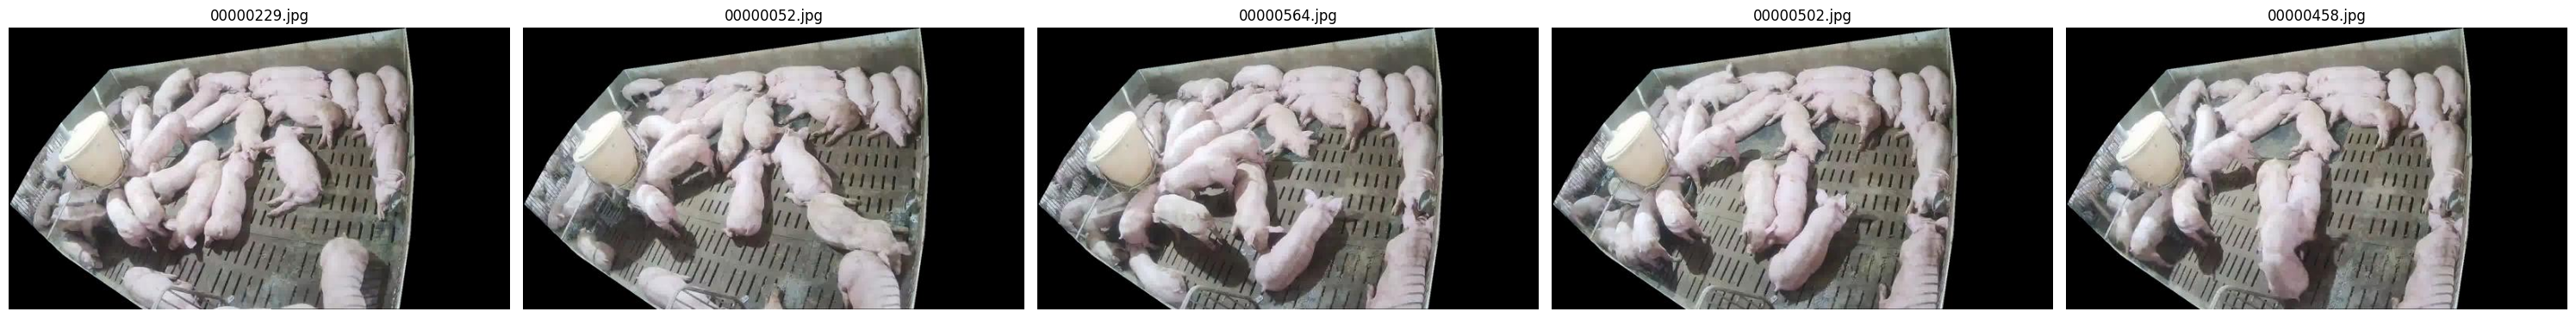

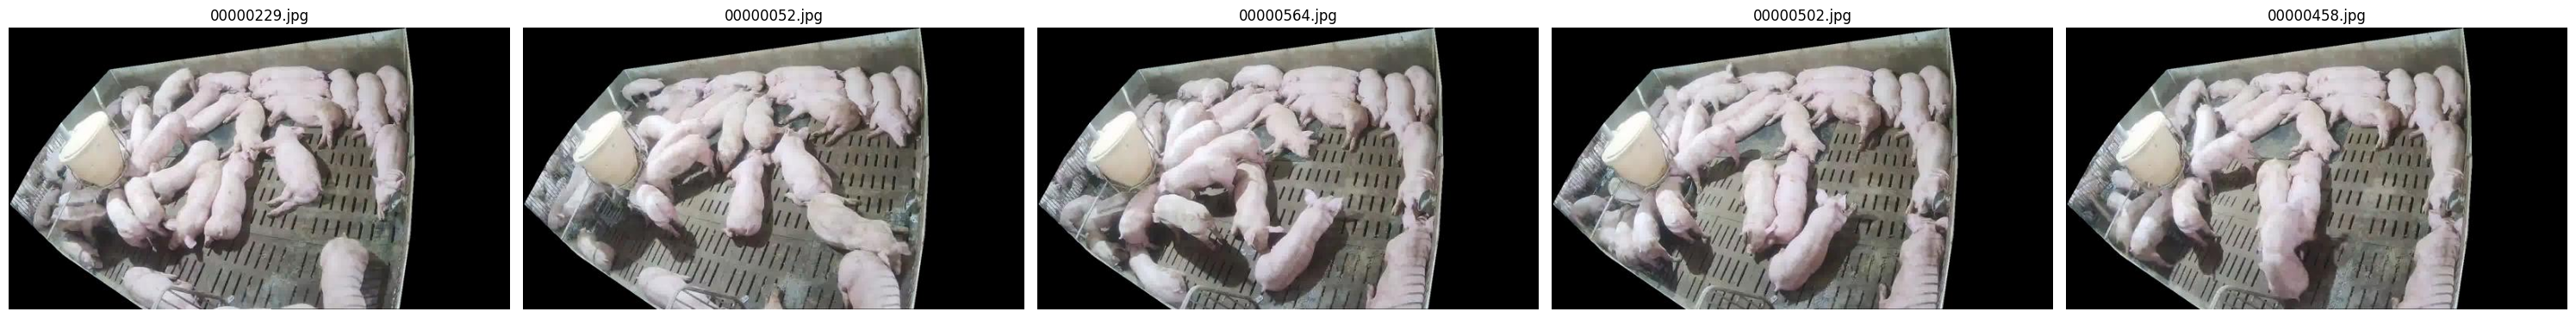

In [ ]:
@torch.no_grad()
def visualize_random_predictions(
    model,
    image_dir: Path,
    num_images: int = 5,
    checkpoint_path: Path | None = None,
    score_threshold: float = 0.5,
    max_detections: int | None = 50,
):
    image_dir = Path(image_dir)
    image_paths = sorted(image_dir.glob("*.jpg"))
    if not image_paths:
        raise ValueError(f"No images found in {image_dir}")

    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))

    if checkpoint_path is not None and checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint from {checkpoint_path}")

    model.eval()
    fig, axes = plt.subplots(1, len(sample_paths), figsize=(6 * len(sample_paths), 6))
    if len(sample_paths) == 1:
        axes = [axes]

    for ax, path in zip(axes, sample_paths):
        detections = run_inference(
            model,
            path,
            score_threshold=score_threshold,
            max_detections=max_detections,
        )
        image = Image.open(path).convert("RGB")
        ax.imshow(image)
        ax.set_title(path.name)
        ax.axis("off")

        boxes_xyxy = detections["boxes_xyxy"]
        scores = detections["scores"]
        for box, score in zip(boxes_xyxy, scores):
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=9, backgroundcolor="white")

    plt.tight_layout()
    plt.show()
    return fig


# Visualize random predictions from the trained model
visualize_random_predictions(
    model,
    image_dir=IMAGES_DIR,
    num_images=5,
    checkpoint_path=OUTPUT_DIR / "best.pth",
    score_threshold=0.5,
    max_detections=50,
)


## Next Steps

- Replace each `### TODO ###` with assignment-specific code for data parsing, model architecture, and evaluation.
- Add experiment tracking (TensorBoard, Weights & Biases, etc.) if desired.
- Integrate assignment-specific metrics and submission formatting.